# Neural Network model for fluid dynamics (Part 2)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/paolodeangelis/Sistemi_a_combustione/blob/main/2.2-NN_Reynolds_P2.ipynb)

## Hypothetical Experiment

Let's imagine an experimental setup as depicted in the sketch below. In this hypothetical scenario, we are examining the flow of incompressible water within a duct, which exhibits various flow regimes. To gather data, we employ a fictional Pitot tube grid to obtain velocity profiles.


<img style="display: block; margin: auto;" alt="Experimental Setup" src="https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/assets/img/NN_problem.png">

The central question we pose in this hypothetical experiment is: Can we effectively utilize a neural network (NN) to analyze and interpret these hypothetical velocity profiles and estimate the Reynolds number $\mathrm{Re}$

## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to `Edit` > `Notebook Settings`
- Select `T4 GPU` from the Hardware Accelerator drop-down
- If the GPU nodes are busy, use the CPU one.

Next, we'll check that we can connect to the GPU:

In [78]:
import warnings

import tensorflow as tf

print("Tensorflow version " + tf.__version__)

device_name = tf.test.gpu_device_name()  # GPU detection
if device_name == "/device:GPU:0":
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f"Running on GPU at: {device_name}")
else:
    warnings.warn("GPU device not found")
    try:
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(
            tpu=""
        )  # TPU detection
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        strategy = tf.distribute.TPUStrategy(resolver)
        print(
            "Running on TPU at:",
            "\n\t".join([f"{i}" for i in tf.config.list_logical_devices("TPU")]),
        )
    except ValueError:
        warnings.warn("TPU device not found")
        warnings.warn("Default parallization strategy will be used")
        strategy = tf.distribute.get_strategy()

Tensorflow version 2.14.0
Running on GPU at: /device:GPU:0


## Installing Libraries

We begin by installing the necessary libraries to support our data manipulation, visualization, and deep learning modeling. (Note: `Tensorflow` and `Keras` are already installed on Colab)

In [79]:
%pip install numpy pandas scipy matplotlib  scikit-learn

And now we import the necessary libraries

In [80]:
import os  # Operating system-related functions
import pathlib  # Path manipulation and filesystem-related operations

import matplotlib.pyplot as plt  # Data visualization library
import numpy as np  # Numerical computing library
import pandas as pd  # Data manipulation and analysis library
import tensorflow as tf  # Deep learning framework for neural networks
from sklearn.metrics import r2_score
from tensorflow.keras import Sequential, layers, losses, optimizers

## Data download and downsamplig

In this section, we will download the dataset and  reduce its size to speed up the training.

### Download dataset files

In [81]:
!wget https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/data/lab2/velprof-Re.csv
!wget https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/data/lab2/velprof-data.csv
!wget https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/data/lab2/velprof-space.csv

--2023-10-31 13:55:35--  https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/data/lab2/velprof-Re.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1500006 (1.4M) [text/plain]
Saving to: ‘velprof-Re.csv.1’

velprof-Re.csv.1    100%[===================>]   1.43M  --.-KB/s    in 0.02s   

2023-10-31 13:55:35 (63.2 MB/s) - ‘velprof-Re.csv.1’ saved [1500006/1500006]

--2023-10-31 13:55:35--  https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/data/lab2/velprof-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awai

### Read Reynolds (the labels for our model)

We'll start by reading the Reynolds data, which serves as the labels for our model.

In [82]:
data_Re = pd.read_csv("velprof-Re.csv", index_col=False)
data_Re.head()

,Re(-)
0,2950.27502
1,194866.84400
2,104938.95600
3,227933.60600
4,9078.88202


### Read the data file (the features for our model)

Next, we'll read the data file containing the features for our model.

In [83]:
data_v = pd.read_csv("velprof-data.csv", index_col=False)
data_v.head()

,mu(Pas),rho(kg/m3),L(m),R(m),vel[0](m/s),vel[1](m/s),vel[2](m/s),vel[3](m/s),vel[4](m/s),vel[5](m/s),...,vel[40](m/s),vel[41](m/s),vel[42](m/s),vel[43](m/s),vel[44](m/s),vel[45](m/s),vel[46](m/s),vel[47](m/s),vel[48](m/s),vel[49](m/s)
0,0.000630,996.232835,69.244194,0.408814,0.004406,0.004405,0.004399,0.004391,0.004379,0.004363,...,0.001583,0.001433,0.001279,0.001119,0.000954,0.000782,0.000604,0.000418,0.000221,0.0
1,0.001484,1117.370480,94.471272,0.352740,0.429010,0.428980,0.428889,0.428737,0.428525,0.428251,...,0.356270,0.349899,0.342721,0.334513,0.324943,0.313467,0.299106,0.279764,0.249233,0.0
2,0.000372,1039.442220,89.215592,0.248828,0.089278,0.089271,0.089251,0.089217,0.089168,0.089106,...,0.072942,0.071524,0.069930,0.068110,0.065993,0.063462,0.060306,0.056076,0.049453,0.0
3,0.000189,1045.145970,20.190082,0.086718,0.277383,0.277364,0.277306,0.277210,0.277076,0.276902,...,0.231210,0.227158,0.222590,0.217365,0.211269,0.203954,0.194793,0.182441,0.162907,0.0
4,0.002309,1086.237000,17.299562,0.136982,0.090704,0.090693,0.090661,0.090606,0.090530,0.090432,...,0.066148,0.064151,0.061931,0.059432,0.056571,0.053219,0.049142,0.043865,0.036045,0.0


Let's also read another data file that contains information about space discretization, which, in our analogy, represents the probe's position.

In [84]:
data_r = pd.read_csv("velprof-space.csv", index_col=False)
data_r.head()

,r[0](m),r[1](m),r[2](m),r[3](m),r[4](m),r[5](m),r[6](m),r[7](m),r[8](m),r[9](m),...,r[40](m),r[41](m),r[42](m),r[43](m),r[44](m),r[45](m),r[46](m),r[47](m),r[48](m),r[49](m)
0,0.0,0.008343,0.016686,0.025029,0.033373,0.041716,0.050059,0.058402,0.066745,0.075088,...,0.333726,0.342069,0.350412,0.358756,0.367099,0.375442,0.383785,0.392128,0.400471,0.408814
1,0.0,0.007199,0.014398,0.021596,0.028795,0.035994,0.043193,0.050391,0.057590,0.064789,...,0.287951,0.295150,0.302349,0.309548,0.316746,0.323945,0.331144,0.338343,0.345541,0.352740
2,0.0,0.005078,0.010156,0.015234,0.020312,0.025391,0.030469,0.035547,0.040625,0.045703,...,0.203125,0.208203,0.213281,0.218359,0.223437,0.228515,0.233593,0.238672,0.243750,0.248828
3,0.0,0.001770,0.003539,0.005309,0.007079,0.008849,0.010618,0.012388,0.014158,0.015928,...,0.070790,0.072560,0.074329,0.076099,0.077869,0.079639,0.081408,0.083178,0.084948,0.086718
4,0.0,0.002796,0.005591,0.008387,0.011182,0.013978,0.016773,0.019569,0.022364,0.025160,...,0.111822,0.114618,0.117414,0.120209,0.123005,0.125800,0.128596,0.131391,0.134187,0.136982


We can also merge the two datasets, which include both labels and features (it can be useful later).

In [85]:
data_all = pd.concat([data_v, data_Re], axis=1)

### Downsampling the database

The dataset contains too many data points (100,000), so we will reduce it to 40,000 by randomly selecting from the entire database.

In [86]:
# Get the total number of data points in data_v
Nall = data_v.shape[0]

# Define the desired number of smaller data points to select
Nsmall = 40000

# Initialize a random number generator with a specific seed for reproducibility
rand_gen = np.random.default_rng(seed=1234)

# Generate a random sample of indices without replacement from the range [0, Nall)
# This will be used to select a subset of data_v and data_Re
indx = rand_gen.choice(np.arange(Nall), size=Nsmall, replace=False)

# Create smaller subsets of data_v and data_Re based on the randomly selected indices
data_v_small = data_v.iloc[indx, :]
data_Re_small = data_Re.iloc[indx, :]

let's store it as `.csv` (comma-separated values)

In [87]:
data_v_small.to_csv("small-data.csv", index=False)
data_Re_small.to_csv("small-Re.csv", index=False)

## Model 2: Re number *regression*


In this section, we will employ our Neural-Network model for *regression* with the primary goal of predicting the reynolds number from the velocity profile.

### Setup database

We load the features and the labels of our first model.

In [88]:
# Note: this time we include the intial coloms contaiong phisical property of the fluid, and channel sizes (mu(Pas)	rho(kg/m3)	L(m)	R(m))
features = pd.read_csv("small-data.csv", index_col=False)
labels = pd.read_csv("small-Re.csv", index_col=False)

Display the first few rows of the features.

In [89]:
features.head()

,mu(Pas),rho(kg/m3),L(m),R(m),vel[0](m/s),vel[1](m/s),vel[2](m/s),vel[3](m/s),vel[4](m/s),vel[5](m/s),...,vel[40](m/s),vel[41](m/s),vel[42](m/s),vel[43](m/s),vel[44](m/s),vel[45](m/s),vel[46](m/s),vel[47](m/s),vel[48](m/s),vel[49](m/s)
0,0.000410,1030.726970,74.998529,0.068560,1.417451,1.417360,1.417088,1.416633,1.415995,1.415172,...,1.197356,1.177895,1.155926,1.130756,1.101335,1.065950,1.021500,0.961324,0.865544,0.0
1,0.000639,1088.630430,63.644387,0.064097,0.874084,0.874021,0.873832,0.873516,0.873072,0.872500,...,0.722647,0.709417,0.694517,0.677490,0.657648,0.633874,0.604152,0.564178,0.501215,0.0
2,0.000815,970.736430,90.121945,0.224744,0.662115,0.662071,0.661939,0.661718,0.661408,0.661008,...,0.555539,0.546150,0.535560,0.523437,0.509280,0.492273,0.470941,0.442122,0.396402,0.0
3,0.001032,1039.847190,32.824149,0.301815,0.005550,0.005548,0.005541,0.005529,0.005513,0.005492,...,0.001852,0.001664,0.001472,0.001276,0.001075,0.000869,0.000659,0.000444,0.000224,-0.0
4,0.000165,957.538049,62.117585,0.465334,0.002068,0.002068,0.002067,0.002066,0.002064,0.002062,...,0.001494,0.001447,0.001395,0.001337,0.001271,0.001193,0.001099,0.000978,0.000798,0.0


Display the first few rows of the labels.

In [90]:
labels.head()

,Re(-)
0,423079.30600
1,162753.22700
2,305589.71000
3,1688.49445
4,8641.48819


To create a training and test dataset, we perform an 80/20 split.

In [91]:
# Splitting the dataset into training and test sets
# Training set (80% of the data)
labels_train = labels.iloc[int(Nsmall * 0.2) :, :]
features_train = features.iloc[int(Nsmall * 0.2) :, :]

# Test set (20% of the data)
labels_test = labels.iloc[: int(Nsmall * 0.2), :]
features_test = features.iloc[: int(Nsmall * 0.2), :]

### Storing

We will store the datasets and labels in a structured folder for future use.

In [92]:
pathlib.Path("model_2").mkdir(parents=True, exist_ok=True)  # Make a folder
# Make train and test subfolders
pathlib.Path(os.path.join("model_2", "train")).mkdir(exist_ok=True)
pathlib.Path(os.path.join("model_2", "test")).mkdir(exist_ok=True)
# Note: This time, we include the initial columns containing physical properties of the fluid and channel sizes (mu (Pas), rho (kg/m³), L (m), R (m)).
labels_train.to_csv(os.path.join("model_2", "train", "labels.csv"), index=False)
labels_test.to_csv(os.path.join("model_2", "test", "labels.csv"), index=False)
features_train.to_csv(os.path.join("model_2", "train", "features.csv"), index=False)
features_test.to_csv(os.path.join("model_2", "test", "features.csv"), index=False)

### First Try

The sketch below represents the proposed neural network architecture.

<img style="display: block; margin: auto;" alt="NN sketch" src="https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/assets/img/NN_model2_try1.png">

#### Architecture

#### Building the Model with Keras and TensorFlow


Now we define a function to create our neural network model using Keras and TensorFlow. This involves designing the layers, specifying their connections, and defining their behavior, including activation functions, regularization, dropout, and more.

In a neural network, a *layer* serves as a fundamental building block responsible for processing data and extracting features. Layers are combined to form the architecture of the neural network. Each layer consists of one or more "neurons" (also known as "nodes" or "units").

For our first model, we need to include the following types of layers:

* **Input Layer**: This is the initial layer that receives raw input data. Its primary role is to pass the data to subsequent layers. The input layer typically has one neuron for each feature present in the input data.

* **Hidden Layers**: These intermediate layers sit between the input and output layers. Hidden layers perform complex transformations on the data, enabling the network to learn and extract features from the input. Each neuron in a hidden layer receives input from multiple neurons in the previous layer.

* **Output Layer**: The final layer in the neural network is responsible for producing the model's predictions. The number of neurons in the output layer depends on the nature of the problem being addressed. For the Reynolds number regression ($\mathrm{Re} \in \left[0, +\infty\right)$), a single neuron is common in the output layer. Here is crucial the choice of the activation function

In addition to layers, we also introduce the concept of an *activation function*. An activation function is a critical element within each neuron of a neural network. It dictates how the output of a neuron is calculated based on its input. The activation function introduces non-linearity into the model, allowing it to learn complex patterns and relationships within the data.

In the following example we are going to use

* **ReLU (Rectified Linear Unit)**: ReLU is one of the most widely used activation functions. It returns the input value if it's positive and zero if it's negative. Mathematically, it can be represented as $f(x) = \max(0, x)$. ReLU is effective in training deep networks and addressing the vanishing gradient problem.

* **Linear**: Basicaly the output neurons gather features from the previous layer and return the result through a matrix operation $\mathbf{W}\mathbf{x} + b$ with $\mathbf{W} \in \mathbb{R}^{1\times N}$, $\mathbf{x} \in \mathbb{R}^{N\times 1}$. Mathematically, it's expressed as $f(x) = x$.


#### Load data

In [93]:
features_train_try1 = pd.read_csv(
    os.path.join("model_2", "train", "features.csv"), index_col=False
).iloc[
    :, 4:
]  # Note: we drop the first 4 columns to study only the velocity profile
features_test_try1 = pd.read_csv(
    os.path.join("model_2", "test", "features.csv"), index_col=False
).iloc[
    :, 4:
]  # Note: we drop the first 4 columns to study only the velocity profile
labels_train_try1 = pd.read_csv(
    os.path.join("model_2", "train", "labels.csv"), index_col=False
)
labels_test_try1 = pd.read_csv(
    os.path.join("model_2", "test", "labels.csv"), index_col=False
)

In [94]:
def build_model_2(n_cols: int, out_activation: str) -> tf.keras.models.Sequential:
    """
    Build a the first possible architecture for our neural network model.

    Args:
        n_cols (int): Number of input features.
        out_activation (str): Output activation function.
    Returns:
        tf.keras.models.Sequential: A Keras Sequential model.
    """
    model = Sequential(
        [
            # Input layer with the specified input shape
            layers.InputLayer(input_shape=(n_cols,), name="input_layer"),
            # Add the first hidden layer with 64 perceptron and ReLU activation
            layers.Dense(64, activation="relu", name="hidden_layer_1"),
            # Add the second hidden layer with 64 perceptron and ReLU activation
            layers.Dense(64, activation="relu", name="hidden_layer_2"),
            # Add the third hidden layer with 64 perceptron and ReLU activation
            layers.Dense(32, activation="relu", name="hidden_layer_3"),
            # Add the forth hidden layer with 64 perceptron and ReLU activation
            layers.Dense(32, activation="relu", name="hidden_layer_4"),
            # Add the output layer with a single perceptron (we expect a True/False answer) and sigmoid activation
            layers.Dense(1, activation=out_activation, name="output_layer"),
        ]
    )
    return model

Let's call the function to build our model.

In [95]:
model = build_model_2(features_train_try1.shape[1], "linear")

#### Model Summary and Structure Visualization

Let's examine the summary of our compiled model and visualize its architecture.

Given that the input data has 50 features and the first hidden layer consists of 64 neurons (each with weights $w$ and biases $b$), we have the following:

- Number of parameters in the first hidden layer ($\mathbf{w}_{h1}$): $50 \times 64 = 3200$
- Number of parameters in the first hidden layer biases ($\mathbf{b}_{h1}$): $1 \times 64 = 64$

The second hidden layer is densely connected with the first one, therefore we have 64 "inputs feature" from the first hidden layer:

- Number of parameters in the first hidden layer ($\mathbf{w}_{h1}$): $64 \times 64 = 4096$
- Number of parameters in the first hidden layer biases ($\mathbf{b}_{h1}$): $1 \times 64 = 64$

The third hidden layer is densely connected with the second one, therefore we have 32 "inputs feature" from the first hidden layer:

- Number of parameters in the first hidden layer ($\mathbf{w}_{h1}$): $64 \times 32 = 2048$
- Number of parameters in the first hidden layer biases ($\mathbf{b}_{h1}$): $1 \times 32 = 32$

The forth hidden layer is densely connected with the third one, therefore we have 32 "inputs feature" from the first hidden layer:

- Number of parameters in the first hidden layer ($\mathbf{w}_{h1}$): $32 \times 32 = 1024$
- Number of parameters in the first hidden layer biases ($\mathbf{b}_{h1}$): $1 \times 32 = 32$

In addition, considering the output layer:

- Number of parameters in the output layer weights ($\mathbf{w}_{o}$): $64 \times 1 = 64$
- Number of parameters in the output layer biases ($\mathbf{b}_{o}$): $64 \times 1 = 1$

This results in a total of $(3200 + 64) + (4096 +64) + (2048 + 32) + (1024 +32) + (64 +1) = 10625 $ degrees of freedom (dofs) within our model.

In [96]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 64)                3264      
                                                                 
 hidden_layer_2 (Dense)      (None, 64)                4160      
                                                                 
 hidden_layer_3 (Dense)      (None, 32)                2080      
                                                                 
 hidden_layer_4 (Dense)      (None, 32)                1056      
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 10593 (41.38 KB)
Trainable params: 10593 (41.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


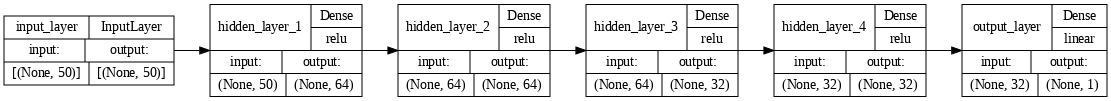

In [97]:
tf.keras.utils.plot_model(
    model=model, rankdir="LR", dpi=72, show_shapes=True, show_layer_activations=True
)

#### Model Compilation

Now we will compile our neural network model. Model compilation involves defining key components, such as the loss function, optimizer, learning rate, and metrics.

##### Loss Function

For our regression task, we use the Mean Absolute Percentage Error (MAPE) loss function. The *Mean Absolute Percentage Error loss is calculated as:

The Mean Absolute Percentage Error (MAPE) loss function can be represented in LaTeX as follows:

$$ MAPE = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100\% $$

where $ n $ is the number of data points, $ y_i $ represents the actual (observed) values, $ \hat{y}_i $ represents the predicted values.

In [98]:
loss = losses.MeanAbsolutePercentageError()

##### Optimizer

We use the *Adam* optimizer, a popular choice for training neural networks. The [Adam optimization algorithm](https://doi.org/10.48550/arXiv.1412.6980) is a neural network-specific adaptation of the [Stochastic Gradient Descent (SGD)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) method.

In [99]:
optimizer = optimizers.Adam(learning_rate=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

##### Metrics

Metrics are functions needed to measure the behavior of our model. There are many to choose from depending on the task of the model. For our case:

- **Root Mean Squared Error (RMSE)**: RMSE is a metric used to evaluate regression models. It measures the square root of the average of the squared differences between predicted and actual values. It quantifies the model's prediction error.

  $$ RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $$

  Where $n$ is the number of data points, $y_i$ represents the actual (observed) values and $\hat{y}_i$ represents the predicted values.

- **Mean Squared Error (MSE)**: MSE is another metric used to evaluate regression models. It is computed as the average of the squared differences between predicted and actual values.

  $$ MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$

  where $n$ is the number of data points, $y_i$ represents the actual (observed) values, and $\hat{y}_i$ represents the predicted values.


In [100]:
metrics = [
    tf.keras.metrics.RootMeanSquaredError(),
    tf.keras.metrics.MeanSquaredError(),
]


##### Compilation

Finally, we compile the model by specifying the optimizer, loss function, and metrics.

In [101]:
model.compile(
    optimizer,
    loss,
    metrics,
)

#### Training
In training, we define two key parameters:

In [102]:
batch_size = 512
epochs = 500

* **Batch Size**: It specifies the number of training examples used in each iteration. A smaller batch size updates the model more frequently, while a larger one may improve training efficiency but requiring more volatile memory (RAM).

* **Epochs**: Each epoch represents one pass through the entire training dataset. It controls how many times the model iterates over the data, influencing convergence and potential overfitting.

Let's (finally) start the training process.

In [103]:
with strategy.scope():
    # These initial lines of code are repeated because they need to be defined
    # inside the parallelization context to efficiently utilize the GPU/TPU.

    # Step 1: Building the Model
    model = build_model_2(features_train_try1.shape[1], "linear")

    # Step 2: Compiling the Model
    loss = losses.MeanAbsolutePercentageError()
    optimizer = optimizers.Adam(
        learning_rate=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-08
    )
    metrics = [
        tf.keras.metrics.RootMeanSquaredError(),
        tf.keras.metrics.MeanSquaredError(),
    ]
    model.compile(
        optimizer,
        loss,
        metrics,
    )

    # Step 3: Training the Model
    history = model.fit(
        np.array(
            features_train_try1
        ),  # Convert the data into an array before feeding it
        np.array(labels_train_try1).astype("float"),
        batch_size,
        epochs,
        validation_data=(
            np.array(features_test_try1),
            np.array(labels_test_try1).astype("float"),
        ),  # Validation set
        verbose=1,  # 0 = silent, 1 = progress bar, 2 = one line per epoch
    )

Epoch 1/400
63/63 [==============================] - 8s 25ms/step - loss: 101.5543 - root_mean_squared_error: 465481.7500 - mean_squared_error: 216673271808.0000 - val_loss: 86.7076 - val_root_mean_squared_error: 403144.3750 - val_mean_squared_error: 162525396992.0000
Epoch 2/400
63/63 [==============================] - 1s 17ms/step - loss: 68.2840 - root_mean_squared_error: 359047.2500 - mean_squared_error: 128914931712.0000 - val_loss: 60.3594 - val_root_mean_squared_error: 328171.2500 - val_mean_squared_error: 107696365568.0000
Epoch 3/400
63/63 [==============================] - 1s 17ms/step - loss: 61.6819 - root_mean_squared_error: 345128.1562 - mean_squared_error: 119113457664.0000 - val_loss: 61.7551 - val_root_mean_squared_error: 333518.1562 - val_mean_squared_error: 111234359296.0000
Epoch 4/400
63/63 [==============================] - 1s 18ms/step - loss: 61.8668 - root_mean_squared_error: 346575.4062 - mean_squared_error: 120114520064.0000 - val_loss: 61.7198 - val_root_mea

#### Plot Training Progress

Now, we can plot the training progress.

In [104]:
# @title Ausiliar plot function


def plot_training(
    ax,
    ax_twin,
    history,
    metric="root_mean_squared_error",
    metric_label="RMSE",
    halflife=25,
):
    """
    Plot training history with specified metric.

    Args:
        ax (Matplotlib Axis): The main plot axis.
        ax_twin (Matplotlib Axis): The twinned plot axis.
        history (Pandas DataFrame): Training history data.
        metric (str): The name of the metric to plot.
        metric_label (str): Label for the metric on the plot.
        halflife (int): Exponential moving average halflife for smoothing.

    Returns:
        None
    """
    ax.plot(history.index, history[metric], color="k", ls="-", alpha=0.25)
    a1 = ax.plot(
        history.index,
        history[metric].ewm(halflife=halflife).mean(),
        color="k",
        ls="-",
        label=metric_label + " (train)",
    )
    ax.plot(history.index, history["val_" + metric], color="k", ls="--", alpha=0.25)
    a2 = ax.plot(
        history.index,
        history["val_" + metric].ewm(halflife=halflife).mean(),
        color="k",
        ls="--",
        label=metric_label + " (test)",
    )
    ax_twin.plot(history.index, history["loss"], color="r", ls="-", alpha=0.25)
    l1 = ax_twin.plot(
        history.index,
        history["loss"].ewm(halflife=halflife).mean(),
        color="r",
        ls="-",
        label="Loss (train)",
    )
    ax_twin.plot(history.index, history["val_loss"], color="r", ls="--", alpha=0.25)
    l2 = ax_twin.plot(
        history.index,
        history["val_loss"].ewm(halflife=halflife).mean(),
        color="r",
        ls="--",
        label="Loss (test)",
    )
    ax.set_xlabel("Epochs [-]")
    ax.set_ylabel(metric_label + " [-]")
    ax_twin.set_ylabel(metric_label + "Loss [-]")
    ax_twin.legend(
        a1 + a2 + l1 + l2,
        [
            metric_label + " (train)",
            metric_label + " (test)",
            "Loss (train)",
            "Loss (test)",
        ],
        loc="upper right",
    )
    metric_data = np.concatenate(
        [
            history[metric].ewm(halflife=halflife).mean().values,
            history["val_" + metric].ewm(halflife=halflife).mean().values,
        ]
    )
    lb, ub = [np.percentile(metric_data, 0.5), np.percentile(metric_data, 99.5)]
    delta = ub - lb
    ax.set_ylim([lb - 0.05 * delta, ub + 0.05 * delta])
    loss_data = np.concatenate(
        [
            history["loss"].ewm(halflife=halflife).mean().values,
            history["val_loss"].ewm(halflife=halflife).mean().values,
        ]
    )
    lb, ub = [np.percentile(loss_data, 0.5), np.percentile(loss_data, 99.5)]
    delta = ub - lb
    ax_twin.set_ylim([lb - 0.05 * delta, ub + 0.05 * delta])


def get_rmsre(y_true, y_pred):
    """
    Get the Root Mean Square Relative Error.

    Args:
        y_true (array-like): True values.
        y_pred (array-like): Predicted values.

    Returns:
        RMSE (float): The Root Mean Square Relative Error.
    """
    return np.sqrt(np.mean(np.square((y_pred - y_true) / y_true)))


def get_mare(y_true, y_pred):
    """
    Get the Max Absolute Relative Error.

    Args:
        y_true (array-like): True values.
        y_pred (array-like): Predicted values.

    Returns:
        MARE (float): The Max Absolute Relative Error.
    """
    return np.max(np.abs(y_pred - y_true) / y_true)


def plot_regression(ax, axins, train_true, train_pred, test_true, test_pred):
    """
    Plot regression results and error distribution.

    Args:
        ax (Matplotlib Axis): The main plot axis.
        axins (Matplotlib Axis): The twinned plot axis.
        train_true (array-like): True values for the training set.
        train_pred (array-like): Predicted values for the training set.
        test_true (array-like): True values for the test set.
        test_pred (array-like): Predicted values for the test set.

    Returns:
        None
    """
    # compute error
    error_test_perc = np.abs(test_pred - test_true) / test_true * 100
    error_train_perc = np.abs(train_pred - train_true) / train_true * 100
    # compute error distibution
    p_test, bins_test = np.histogram(np.log(error_test_perc), bins=200, density=True)
    x_bins_test = (bins_test[1:] + bins_test[:-1]) / 2
    p_train, bins_train = np.histogram(np.log(error_train_perc), bins=200, density=True)
    x_bins_train = (bins_train[1:] + bins_train[:-1]) / 2
    # compute some more metrhics
    r2_test = r2_score(test_true, test_pred)
    r2_train = r2_score(train_true, train_pred)
    RMSRE_test = get_rmsre(test_true, test_pred) * 100.0
    RMSRE_train = get_rmsre(train_true, train_pred) * 100.0
    MARE_test = get_mare(test_true, test_pred) * 100.0
    MARE_train = get_mare(train_true, train_pred) * 100.0
    # train
    ax.scatter(train_true, train_pred, s=4, alpha=0.2, color="#126fbf", label="Train")
    axins.fill_between(
        np.exp(x_bins_train),
        p_train * 0.0,
        p_train,
        alpha=0.4,
        color="#126fbf",
        label="Train",
    )
    axins.plot(np.exp(x_bins_train), p_train, color="#126fbf", lw=1.2)
    # test
    ax.scatter(test_true, test_pred, s=4, alpha=0.2, color="#f3702b", label="Test")
    axins.fill_between(
        np.exp(x_bins_test),
        p_test * 0.0,
        p_test,
        alpha=0.4,
        color="#f3702b",
        label="Test",
    )
    axins.plot(np.exp(x_bins_test), p_test, color="#f3702b", lw=1.2)
    # additional metrics
    ax.annotate(
        f"Train:\n\t $R^2 = {r2_train:1.3f}"
        + f"$\n\t $RMSRE = {RMSRE_train:1.3f}$ % "
        + f"\n\t $MARE = {MARE_train:1.3f}$ % \n"
        + f"Test:\n\t $R^2 = {r2_test:1.3f}$"
        + f"\n\t $RMSRE = {RMSRE_test:1.3f}$ %"
        + f"\n\t $MARE = {MARE_test:1.3f}$ %",
        xy=(1.05, 0.5),
        xycoords=ax.transAxes,
        va="center",
    )
    ax.set_xlim([50e-2, 5e6])
    ax.set_ylim([50e-2, 5e6])
    ax.set_aspect("equal", adjustable="datalim")
    ax.axline([0, 0], [1, 1], color="k", ls="--", lw=0.75)
    ax.legend(loc="lower right")
    ax.set_xlabel(r"True $\mathrm{Re}$ [-]")
    ax.set_ylabel(r"Prediction $\mathrm{Re}$ [-]")
    axins.legend(loc="upper left")
    axins.set_xlabel("Relative error [%]")
    axins.set_ylabel("Probability density [-]")

In [105]:
# Plot traing
training_history_try1 = pd.DataFrame(history.history)

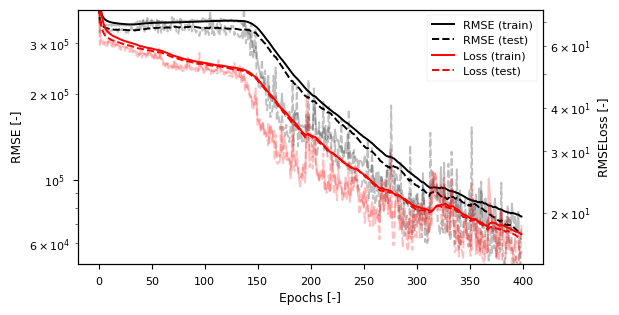

In [106]:
fig = plt.figure(figsize=(6, 3.3))
with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)
    ax_twin = ax.twinx()
    plot_training(
        ax,
        ax_twin,
        training_history_try1,
        metric="root_mean_squared_error",
        metric_label="RMSE",
        halflife=20,
    )
    ax.set_yscale("log")
    ax_twin.set_yscale("log")
plt.show()

#### Model result analysis

Let's compare the model's predictions with the Reynolds number.

In [107]:
# Predictions are generated using the model over the test set,
# which the model has never seen during training.
real_test_Re = np.array(labels_test_try1)
prediction_test_Re = model.predict(np.array(features_test_try1))
real_train_Re = np.array(labels_train_try1)
prediction_train_Re = model.predict(np.array(features_train_try1))

1000/1000 [==============================] - 3s 3ms/step


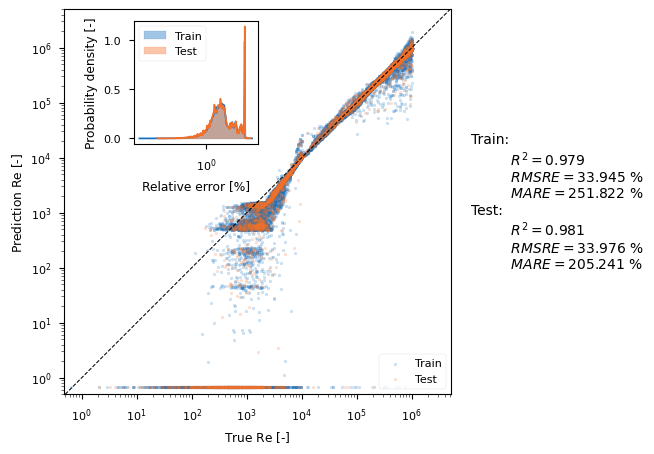

In [108]:
fig = plt.figure(figsize=(5, 5))
with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)
    axins = ax.inset_axes([0.18, 0.65, 0.32, 0.32])
    plot_regression(
        ax, axins, real_train_Re, prediction_train_Re, real_test_Re, prediction_test_Re
    )
    ax.set_xscale("log")
    ax.set_yscale("log")
    axins.set_xscale("log")

### Exercise 1: Activation function

Let's explore some of the activation functions provided by`Tensorflow`:

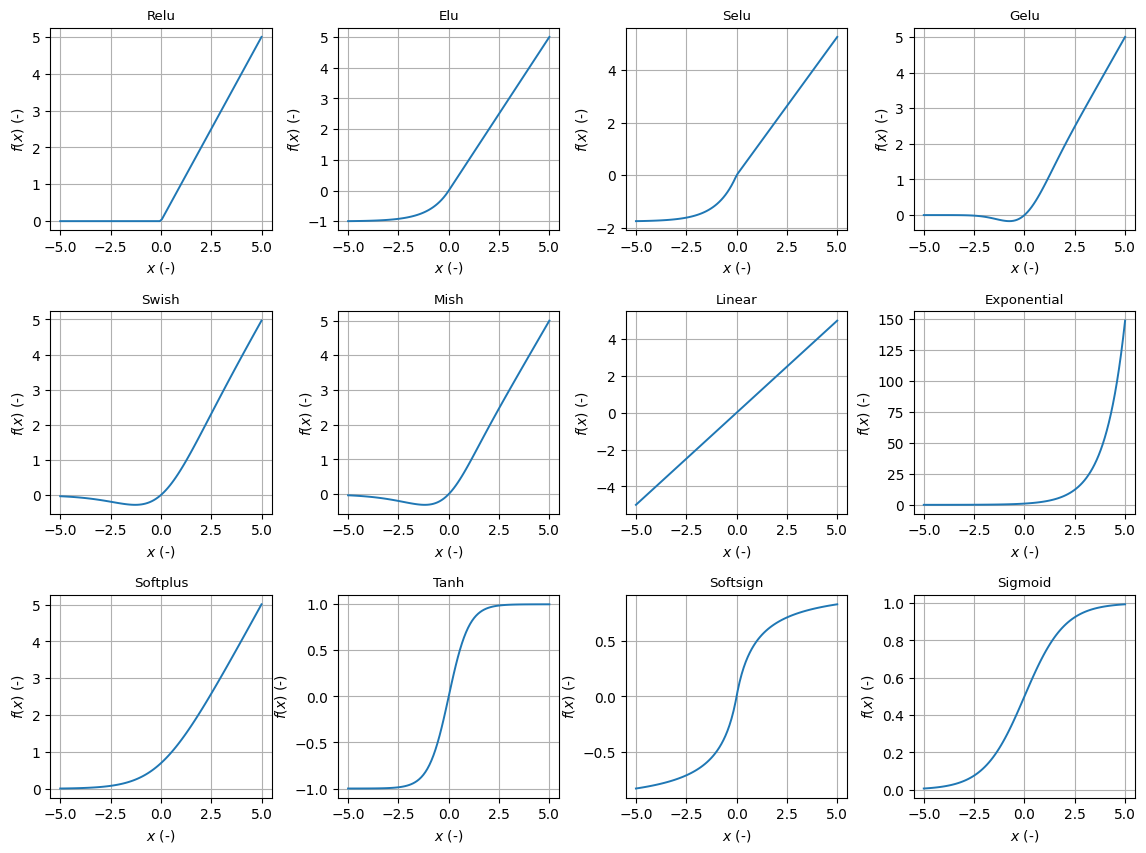

In [109]:
# List of activation function names
activation_functions = [
    "relu",
    "elu",
    "selu",
    "gelu",
    "swish",
    "mish",
    "linear",
    "exponential",
    "softplus",
    "tanh",
    "softsign",
    "sigmoid",
]

# Create TensorFlow constant input
x = tf.constant(np.linspace(-5, 5, 100), dtype=tf.float32)

# Create a grid of subplots
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(3, 4, hspace=0.4, wspace=0.3)
axs = gs.subplots()

# Plot activation functions
with plt.style.context("seaborn-v0_8-paper"):
    for i, activation_name in enumerate(activation_functions):
        row, col = i // 4, i % 4
        activation_func = getattr(tf.keras.activations, activation_name)
        y = activation_func(x)

        axs[row, col].plot(x, y, label=activation_name.capitalize())
        axs[row, col].set_xlabel("$x$ (-)")
        axs[row, col].set_ylabel("$f(x)$ (-)")
        axs[row, col].set_title(activation_name.capitalize())
        axs[row, col].grid()

plt.show()

For our regression model, determining the optimal activation function is essential. Let's perform a sensitivity analysis together by retraining the model with various activation functions available in TensorFlow. This exploration will help us identify the activation function that yields the best performance for our regression task

In [110]:
ACTIVATION = "linear"  # <--- Place here the one with the best metrics

### Second Try: Increase inputs information

In this second experiment, we aim to explore the impact of increasing the dimensionality of the problem by incorporating additional information as inputs to the model, not limited to just the velocity profile.

Within our dataset, we possess valuable information about the physical properties of the fluid ($\mu \,\text{(Pas)}$, $\rho \,\mathrm{(kg/m^3)}$) and the geometric characteristics of the experimental setup ($L \,\text{(m)}$, $R \,\text{(m3)}$). These data are readily available for the model and can enhance its performance.

Furthermore, we can compute the partial derivative of the velocity profile $\dfrac{\partial u_y}{\partial x}$, which we will later discover is closely linked to the velocity stress tensor.

#### Architecture

Since the input shape changes drastically, as a rule of thumb, we increase the width of the model.

The sketch below represents the proposed neural network architecture.

<img style="display: block; margin: auto;" alt="NN sketch" src="https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/assets/img/NN_model2_try2.png">

#### Load data

In [111]:
# Note: we are going to use all the data incluse the phisical properties (mu(Pas),	rho(kg/m3))
# and the gemetrical data (L(m),	R(m))
features_train_try2 = pd.read_csv(
    os.path.join("model_2", "train", "features.csv"), index_col=False
)
features_test_try2 = pd.read_csv(
    os.path.join("model_2", "test", "features.csv"), index_col=False
)
labels_train_try2 = pd.read_csv(
    os.path.join("model_2", "train", "labels.csv"), index_col=False
)
labels_test_try2 = pd.read_csv(
    os.path.join("model_2", "test", "labels.csv"), index_col=False
)

Let's increase futher more the input information computing the derivative

$$ \left[\nabla \mathbf{u} \right]_{ij} = \partial_i u_j =  \dfrac{\partial u_y}{\partial x} \approx \dfrac{u_y^n+1 - u_y^n}{\Delta x}$$

Note that for the Navier-Stoke for compressible fluids ($\rho = \rho_0 = \mathrm{const}(t)$):

$$ \rho_0\dfrac{\partial \mathbf{u}}{\partial t} + \rho_0(\mathbf{u} \cdot \nabla) \mathbf{u} = - \nabla p + \nabla\cdot\mathbf{\tau}   + \rho_0\mathbf{g}  $$

where the stress tensor $\mathbf{\tau}$
$$ \mathbf{\tau} =  \mu \left(\nabla\mathbf{u} + \left(\nabla\mathbf{u}\right)^\text{T} \right) $$

So what we are including as information is proportional to the $ij=ji$ component of the sress tensor.

In [112]:
# Extract the velocity data and radii from the training and test datasets
velocity_train = features_train_try2.iloc[:, 4:].values
R_train = features_train_try2["R(m)"].values
velocity_test = features_test_try2.iloc[:, 4:].values
R_test = features_test_try2["R(m)"].values

# Determine the number of columns (velocity components) in the data
N = velocity_train.shape[1]

# Calculate the velocity gradient (dudx) for the training dataset
dudx_train = pd.DataFrame(
    data=(velocity_train[:, :-1] - velocity_train[:, 1:])
    / (R_train[..., np.newaxis].repeat(N - 1, axis=1) / N),
    columns=[f"dudx[{i:d}]" for i in range(N - 1)],
)

# Calculate the velocity gradient (dudx) for the test dataset
dudx_test = pd.DataFrame(
    data=(velocity_test[:, :-1] - velocity_test[:, 1:])
    / (R_test[..., np.newaxis].repeat(N - 1, axis=1) / N),
    columns=[f"dudx[{i:d}]" for i in range(N - 1)],
)

Let's glue the new data to the input features

In [113]:
features_train_try2_full = pd.concat([features_train_try2, dudx_train], axis=1)
features_test_try2_full = pd.concat([features_test_try2, dudx_test], axis=1)

In [114]:
features_train_try2_full.head()

,mu(Pas),rho(kg/m3),L(m),R(m),vel[0](m/s),vel[1](m/s),vel[2](m/s),vel[3](m/s),vel[4](m/s),vel[5](m/s),...,dudx[39],dudx[40],dudx[41],dudx[42],dudx[43],dudx[44],dudx[45],dudx[46],dudx[47],dudx[48]
0,0.000974,964.250033,27.188673,0.098575,2.068694,2.068559,2.068152,2.067472,2.066520,2.065291,...,13.159903,14.682055,16.566753,18.971525,22.163509,26.637467,33.432511,45.206605,71.815921,633.411487
1,0.000995,1035.580830,33.355809,0.359572,0.677252,0.677208,0.677079,0.676863,0.676559,0.676168,...,1.154157,1.288207,1.454283,1.666327,1.947999,2.343146,2.943944,3.986436,6.347422,57.634546
2,0.000232,997.379932,64.003419,0.286409,0.436054,0.436029,0.435952,0.435824,0.435645,0.435414,...,0.867548,0.969533,1.096106,1.258028,1.473598,1.776802,2.239268,3.045050,4.881288,48.509631
3,0.000269,982.389890,29.093040,0.206085,0.553449,0.553416,0.553316,0.553149,0.552915,0.552613,...,1.567657,1.751235,1.978942,2.270063,2.657362,3.201650,4.030992,5.474093,8.756138,84.464307
4,0.001278,1022.062090,27.814522,0.149329,0.052713,0.052707,0.052689,0.052658,0.052615,0.052560,...,0.343980,0.379178,0.422016,0.475639,0.545284,0.640457,0.780626,1.014010,1.511043,7.250085


#### Model building

In [117]:
def build_model_2_wide(n_cols: int, out_activation: str) -> tf.keras.models.Sequential:
    """
    Build a the first possible architecture for our neural network model.

    Args:
        n_cols (int): Number of input features.
        out_activation (str): Output activation function.
    Returns:
        tf.keras.models.Sequential: A Keras Sequential model.
    """
    model = Sequential(
        [
            # Input layer with the specified input shape
            layers.InputLayer(input_shape=(n_cols,), name="input_layer"),
            # Add the first hidden layer with 64 perceptron and ReLU activation
            layers.Dense(128, activation="relu", name="hidden_layer_1"),
            # Add the second hidden layer with 64 perceptron and ReLU activation
            layers.Dense(128, activation="relu", name="hidden_layer_2"),
            # Add the third hidden layer with 64 perceptron and ReLU activation
            layers.Dense(64, activation="relu", name="hidden_layer_3"),
            # Add the fourth hidden layer with 64 perceptron and ReLU activation
            layers.Dense(64, activation="relu", name="hidden_layer_4"),
            # Add the output layer with a single perceptron (we expect a True/False answer) and sigmoid activation
            layers.Dense(1, activation=out_activation, name="output_layer"),
        ]
    )
    return model

Let's call the function to build our model.

In [118]:
model_v2 = build_model_2_wide(features_train_try2_full.shape[1], ACTIVATION)

#### Model Summary and Structure Visualization

In [119]:
model_v2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 128)               13312     
                                                                 
 hidden_layer_2 (Dense)      (None, 128)               16512     
                                                                 
 hidden_layer_3 (Dense)      (None, 64)                8256      
                                                                 
 hidden_layer_4 (Dense)      (None, 64)                4160      
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 42305 (165.25 KB)
Trainable params: 42305 (165.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


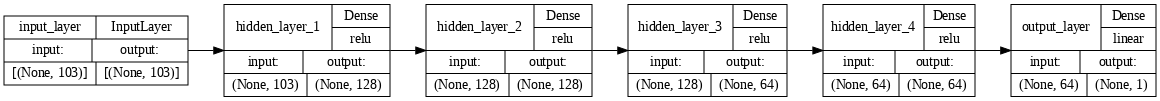

In [120]:
tf.keras.utils.plot_model(
    model=model_v2, rankdir="LR", dpi=72, show_shapes=True, show_layer_activations=True
)

#### Model Compilation And Training

Now we will compile our neural network model. Model compilation involves defining key components, such as the loss function, optimizer, learning rate, and metrics. And then we train the new model.

In [151]:
batch_size = 512
epochs = 500

In [152]:
with strategy.scope():
    # These initla lines of code are repeated because it must be defined
    # inside the parallelization context for efficient GPU/TPU utilization.

    # Step 1: Building the Model
    model_v2 = build_model_2_wide(features_train_try2_full.shape[1], ACTIVATION)

    # Step 2: Compiling the Model
    loss = losses.MeanAbsolutePercentageError()
    optimizer = optimizers.Adam(
        learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08
    )
    metrics = [
        tf.keras.metrics.RootMeanSquaredError(),
        tf.keras.metrics.MeanSquaredError(),
    ]
    model_v2.compile(
        optimizer,
        loss,
        metrics,
    )

    # Step 3: Training the Model
    history = model_v2.fit(
        np.array(
            features_train_try2_full
        ),  # Convert the data into an array before feeding it
        np.array(labels_train_try2).astype("float"),
        batch_size,
        epochs,
        validation_data=(
            np.array(features_test_try2_full),
            np.array(labels_test_try2).astype("float"),
        ),  # Validation set
        verbose=1,  # 0 = silent, 1 = progress bar, 2 = one line per epoch
    )

Epoch 1/500
63/63 [==============================] - 2s 13ms/step - loss: 103.1543 - root_mean_squared_error: 485249.5625 - mean_squared_error: 235467145216.0000 - val_loss: 100.2499 - val_root_mean_squared_error: 479585.0312 - val_mean_squared_error: 230001803264.0000
Epoch 2/500
63/63 [==============================] - 1s 12ms/step - loss: 100.6328 - root_mean_squared_error: 482215.5938 - mean_squared_error: 232531886080.0000 - val_loss: 101.1737 - val_root_mean_squared_error: 471447.7500 - val_mean_squared_error: 222262984704.0000
Epoch 3/500
63/63 [==============================] - 1s 11ms/step - loss: 97.2575 - root_mean_squared_error: 460613.6875 - mean_squared_error: 212164968448.0000 - val_loss: 92.2790 - val_root_mean_squared_error: 433686.0000 - val_mean_squared_error: 188083552256.0000
Epoch 4/500
63/63 [==============================] - 1s 9ms/step - loss: 89.4922 - root_mean_squared_error: 426544.3125 - mean_squared_error: 181940043776.0000 - val_loss: 88.4196 - val_root_m

#### Plot Training Progress

Now, we can plot the training progress.

In [153]:
# Plot traing loop
training_history_try2 = pd.DataFrame(history.history)

In [154]:
training_history_try2.head()

,loss,root_mean_squared_error,mean_squared_error,val_loss,val_root_mean_squared_error,val_mean_squared_error
0,103.154335,485249.56250,2.354671e+11,100.249878,479585.03125,2.300018e+11
1,100.632797,482215.59375,2.325319e+11,101.173676,471447.75000,2.222630e+11
2,97.257507,460613.68750,2.121650e+11,92.278969,433686.00000,1.880836e+11
3,89.492210,426544.31250,1.819400e+11,88.419624,418076.56250,1.747880e+11
4,87.644211,424348.25000,1.800714e+11,98.560036,413525.03125,1.710030e+11


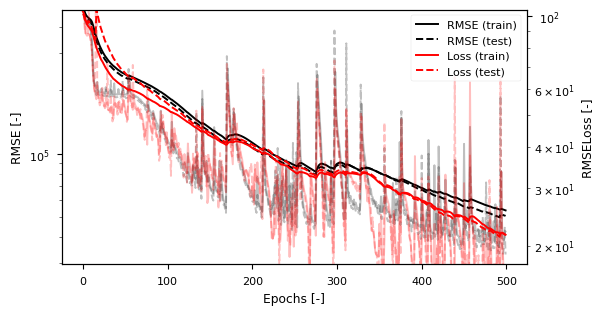

In [155]:
fig = plt.figure(figsize=(6, 3.3))
with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)
    ax_twin = ax.twinx()
    plot_training(
        ax,
        ax_twin,
        training_history_try2,
        metric="root_mean_squared_error",
        metric_label="RMSE",
        halflife=50,
    )
    ax.set_yscale("log")
    ax_twin.set_yscale("log")
plt.show()

#### Model result analysis

Let's compare the model's predictions with the Reynolds number.

In [156]:
# Predictions are generated using the model over the test set,
# which the model has never seen during training.
real_test_Re = np.array(labels_test_try2)
prediction_test_Re = model_v2.predict(np.array(features_test_try2_full))
real_train_Re = np.array(labels_train_try2)
prediction_train_Re = model_v2.predict(np.array(features_train_try2_full))

1000/1000 [==============================] - 3s 3ms/step


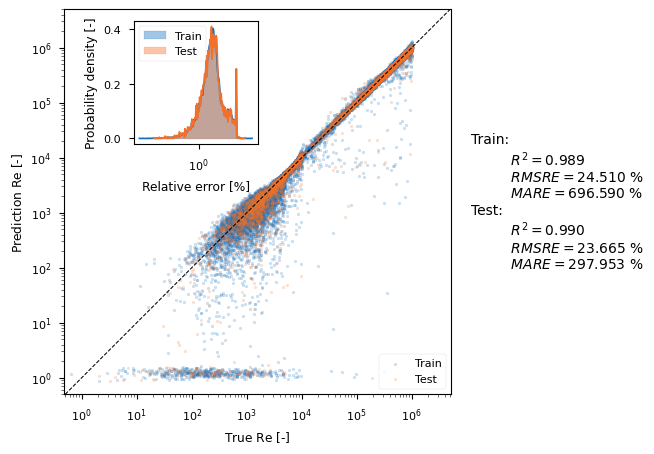

In [157]:
fig = plt.figure(figsize=(5, 5))
with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)
    axins = ax.inset_axes([0.18, 0.65, 0.32, 0.32])
    plot_regression(
        ax, axins, real_train_Re, prediction_train_Re, real_test_Re, prediction_test_Re
    )
    ax.set_xscale("log")
    ax.set_yscale("log")
    axins.set_xscale("log")

### Third Try: Normalization on the fly

#### Architecture

Since the input shape changes drastically, as a rule of thumb, we increase the width of the model.

The sketch below represents the proposed neural network architecture.

<img style="display: block; margin: auto;" alt="NN sketch" src="https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/assets/img/NN_model2_try3.png">

#### Load data

In [128]:
features_train_try3 = pd.read_csv(
    os.path.join("model_2", "train", "features.csv"), index_col=False
).iloc[
    :, 4:
]  # Note: we drop the first 4 columns to study only the velocity profile
features_test_try3 = pd.read_csv(
    os.path.join("model_2", "test", "features.csv"), index_col=False
).iloc[
    :, 4:
]  # Note: we drop the first 4 columns to study only the velocity profile
labels_train_try3 = pd.read_csv(
    os.path.join("model_2", "train", "labels.csv"), index_col=False
)
labels_test_try3 = pd.read_csv(
    os.path.join("model_2", "test", "labels.csv"), index_col=False
)

#### Model building

##### Make custom *normalization* layer

It is important to normalize input data for neural network (NN) training for the following reasons:

* **Stability and Convergence**: Normalization helps in stabilizing the training process. When input features have significantly different scales, it can lead to slow convergence or the network getting stuck in local minima during training. By normalizing the data, the optimization algorithm can work more effectively and converge faster.

* **Gradient Descent**: During gradient descent, the learning rate plays a crucial role. If input features are not normalized, the learning rate might need to be adjusted manually to prevent divergence or slow convergence. Normalized data reduces the sensitivity to the learning rate, making it easier to find a good learning rate automatically.

* **Improved Generalization**: Normalization can lead to better generalization of the model.

* **Model Interpretability**: Normalized data can make it easier to interpret the importance of features in the model. Without normalization, the magnitude of feature weights in the neural network may not accurately reflect their importance.

Now, let's write a custom layer `VelocityNormalization`` that perform the normalization of the velocity profile, and at the same time, add the maximum velocity to the data.


In [129]:
class VelocityNormalization(layers.Layer):
    def __init__(self, axis=1, name="velocity_normalization", **kwargs):
        super().__init__(name=name, **kwargs)
        self.axis = axis

    def call(self, batch):
        batch_max = tf.reduce_max(batch, axis=self.axis, keepdims=True)
        normalized_batch = batch / batch_max
        normalized_with_scale = tf.concat([normalized_batch, batch_max], axis=self.axis)
        return normalized_with_scale

    def compute_output_shape(self, input_shape):
        output_shape = list(input_shape)
        output_shape[self.axis] += 1  # One additional element for the scale vector
        return tuple(output_shape)

In [130]:
# Convert the NumPy array to a TensorFlow constant
input_data_tf = tf.constant(features_train_try3.iloc[:4, :].values, dtype=tf.float32)

# Create a VelocityNormalization layer
batch_max_norm_layer = VelocityNormalization()

# Normalize the input data using the VelocityNormalization layer
normalized_data = batch_max_norm_layer(input_data_tf)

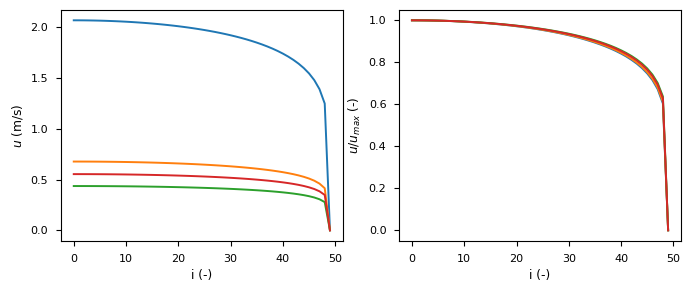

In [131]:
# Create a plot of random data from the datasets
fig = plt.figure(figsize=(8, 3))
# Set the style of the plot to "seaborn-v0_8-paper"
with plt.style.context("seaborn-v0_8-paper"):
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    # Plot the data and labels it with Re value
    for i in range(input_data_tf.shape[0]):
        ax1.plot(input_data_tf[i].numpy())
        ax2.plot(normalized_data[i].numpy()[:-1])

    # Adding labels and titles to the plot
    ax1.set_xlabel("i (-)")
    ax1.set_ylabel("$u$ (m/s)")
    ax2.set_xlabel("i (-)")
    ax2.set_ylabel("$u/u_{max}$ (-)")

In [158]:
def build_model_2_norm(n_cols: int, out_activation: str) -> tf.keras.models.Sequential:
    """
    Build a the second possible architecture for our neural network model.

    Args:
        n_cols (int): Number of input features.
        out_activation (str): Output activation function.
    Returns:
        tf.keras.models.Sequential: A Keras Sequential model.
    """
    model = Sequential(
        [
            # Input layer with the specified input shape
            layers.InputLayer(input_shape=(n_cols,), name="input_layer"),
            # Normalization layer
            VelocityNormalization(name="normalization"),
            # Add the first hidden layer with 64 perceptron and ReLU activation
            layers.Dense(64, activation="relu", name="hidden_layer_1"),
            # Add the second hidden layer with 64 perceptron and ReLU activation
            layers.Dense(64, activation="relu", name="hidden_layer_2"),
            # Add the third hidden layer with 64 perceptron and ReLU activation
            layers.Dense(32, activation="relu", name="hidden_layer_3"),
            # Add the forth hidden layer with 64 perceptron and ReLU activation
            layers.Dense(32, activation="relu", name="hidden_layer_4"),
            # Add the output layer with a single perceptron (we expect a True/False answer) and sigmoid activation
            layers.Dense(1, activation=out_activation, name="output_layer"),
        ]
    )
    return model

In [159]:
model_v3 = build_model_2_norm(features_train_try3.shape[1], ACTIVATION)

#### Model Summary and Structure Visualization



In [160]:
model_v3.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (VelocityNor  (None, 51)                0         
 malization)                                                     
                                                                 
 hidden_layer_1 (Dense)      (None, 64)                3328      
                                                                 
 hidden_layer_2 (Dense)      (None, 64)                4160      
                                                                 
 hidden_layer_3 (Dense)      (None, 32)                2080      
                                                                 
 hidden_layer_4 (Dense)      (None, 32)                1056      
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                     

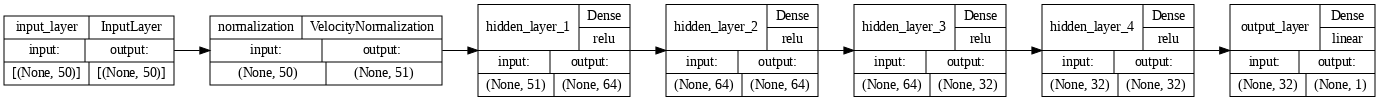

In [161]:
tf.keras.utils.plot_model(
    model=model_v3, rankdir="LR", dpi=72, show_shapes=True, show_layer_activations=True
)

#### Model Compilation And Training

Now we will compile our neural network model. Model compilation involves defining key components, such as the loss function, optimizer, learning rate, and metrics. And then we train the new model.

In [162]:
batch_size = 512
epochs = 500

In [163]:
with strategy.scope():
    # These initla lines of code are repeated because it must be defined
    # inside the parallelization context for efficient GPU/TPU utilization.

    # Step 1: Building the Model
    model_v3 = build_model_2_norm(features_train_try3.shape[1], ACTIVATION)

    # Step 2: Compiling the Model
    loss = losses.MeanAbsolutePercentageError()
    optimizer = optimizers.Adam(
        learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08
    )
    metrics = [
        tf.keras.metrics.RootMeanSquaredError(),
        tf.keras.metrics.MeanSquaredError(),
    ]
    model_v3.compile(
        optimizer,
        loss,
        metrics,
    )

    # Step 3: Training the Model
    history = model_v3.fit(
        np.array(
            features_train_try3
        ),  # Convert the data into an array before feeding it
        np.array(labels_train_try3).astype("float"),
        batch_size,
        epochs,
        validation_data=(
            np.array(features_test_try3),
            np.array(labels_test_try3).astype("float"),
        ),  # Validation set
        verbose=1,  # 0 = silent, 1 = progress bar, 2 = one line per epoch
    )

Epoch 1/500
63/63 [==============================] - 2s 9ms/step - loss: 99.9788 - root_mean_squared_error: 485569.5000 - mean_squared_error: 235777753088.0000 - val_loss: 99.9008 - val_root_mean_squared_error: 480245.1562 - val_mean_squared_error: 230635405312.0000
Epoch 2/500
63/63 [==============================] - 0s 7ms/step - loss: 99.9008 - root_mean_squared_error: 485566.9062 - mean_squared_error: 235775213568.0000 - val_loss: 99.8949 - val_root_mean_squared_error: 480238.4688 - val_mean_squared_error: 230628999168.0000
Epoch 3/500
63/63 [==============================] - 0s 7ms/step - loss: 100.4870 - root_mean_squared_error: 485538.9688 - mean_squared_error: 235748098048.0000 - val_loss: 100.1300 - val_root_mean_squared_error: 480218.5625 - val_mean_squared_error: 230609879040.0000
Epoch 4/500
63/63 [==============================] - 0s 7ms/step - loss: 99.9577 - root_mean_squared_error: 485546.3750 - mean_squared_error: 235755290624.0000 - val_loss: 100.0342 - val_root_mean_

#### Plot Training Progress

Now, we can plot the training progress.

In [164]:
# Plot traing loop
training_history_try3 = pd.DataFrame(history.history)

In [165]:
training_history_try3.head()

,loss,root_mean_squared_error,mean_squared_error,val_loss,val_root_mean_squared_error,val_mean_squared_error
0,99.978790,485569.50000,2.357778e+11,99.900841,480245.15625,2.306354e+11
1,99.900780,485566.90625,2.357752e+11,99.894920,480238.46875,2.306290e+11
2,100.486961,485538.96875,2.357481e+11,100.129967,480218.56250,2.306099e+11
3,99.957657,485546.37500,2.357553e+11,100.034180,480222.59375,2.306137e+11
4,99.904251,485547.46875,2.357564e+11,99.974426,480225.90625,2.306169e+11


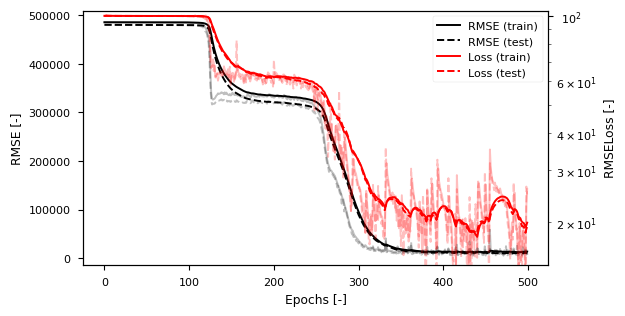

In [166]:
fig = plt.figure(figsize=(6, 3.3))
with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)
    ax_twin = ax.twinx()
    plot_training(
        ax,
        ax_twin,
        training_history_try3,
        metric="root_mean_squared_error",
        metric_label="RMSE",
        halflife=10,
    )
    # ax.set_yscale("log")
    ax_twin.set_yscale("log")
plt.show()

#### Model result analysis

Let's compare the model's predictions with the Reynolds number.

In [167]:
# Predictions are generated using the model over the test set,
# which the model has never seen during training.
real_test_Re = np.array(labels_test_try3)
prediction_test_Re = model_v3.predict(np.array(features_test_try3))
real_train_Re = np.array(labels_train_try3)
prediction_train_Re = model_v3.predict(np.array(features_train_try3))

1000/1000 [==============================] - 2s 2ms/step


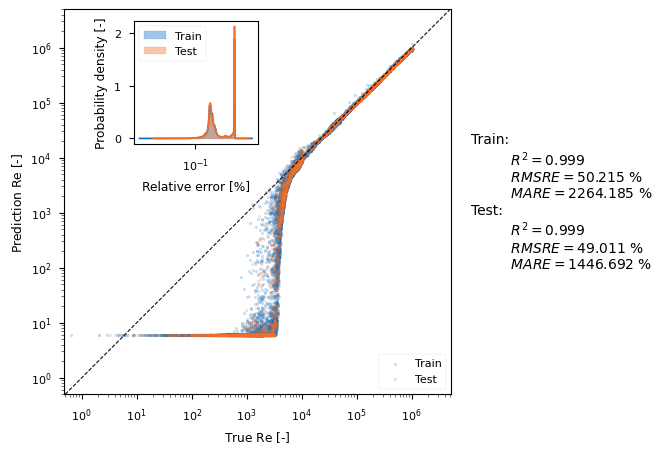

In [168]:
fig = plt.figure(figsize=(5, 5))
with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)
    axins = ax.inset_axes([0.18, 0.65, 0.32, 0.32])
    plot_regression(
        ax, axins, real_train_Re, prediction_train_Re, real_test_Re, prediction_test_Re
    )
    ax.set_xscale("log")
    ax.set_yscale("log")
    axins.set_xscale("log")

### Exercise 2: Can NN predict Velocity profile

Knowing the physical properties of the fluid ($\mu \,\text{(Pas)}$, $\rho \,\mathrm{(kg/m^3)}$) and the geometric characteristics of the experimental setup ($L \,\text{(m)}$, $R \,\text{(m3)}$) and the Raynolds number ($\mathrm{Re} \,\mathrm{(-)}$), can we build a model that predict the velocity profile?

steps:
- Design a architecture
- Chose a loss function and metrics
- Compile the model
- Training
- Visualize the result